In [1]:
import pandas as pd
import numpy as np
import os
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
fpath = '../../../db-processing/survey_responses.tsv'
surveys = pd.read_csv(fpath, sep='\t')

fpath_codes = '../../../db-processing/ad_codes.tsv'
codes = pd.read_csv(fpath_codes, sep='\t')

adid_codes = dict(zip(codes['adid'], [r.split(';') for r in codes['codes']]))
survey_codes = surveys.merge(codes, 'inner', 'adid')

with open('../../../db-processing/participant-demographics/pid_active_contribs.txt', 'r') as fh:
    pids_active = fh.readlines()
    pids_active = [p.strip() for p in pids_active]

In [74]:
pid_codecounts = {p: Counter() for p in pids_active}
pid_joint_codecounts = {p: Counter() for p in pids_active}   # combination of codes counts

for i in range(survey_codes.shape[0]):
    row = survey_codes.iloc[i]
    codes = row['codes']
    pid = row['pid']
    if pid not in pids_active:
        continue
        
    pid_joint_codecounts[pid][codes] += 1
    for c in codes.split(';'):    
        pid_codecounts[pid][c] += 1        

In [95]:
pid_codecounts

{'978584': Counter({'Benign': 41,
          'Financial': 11,
          'Clickbait': 11,
          'Potentially Harmful': 6,
          'Potentially Prohibited': 3,
          'Opportunity': 16,
          'Political': 1,
          'Healthcare': 10,
          'Sensitive': 1,
          'Study': 1}),
 '950668': Counter({'Benign': 25,
          'Study': 10,
          'Healthcare': 12,
          'Opportunity': 9,
          'Financial': 5,
          'Potentially Prohibited': 2,
          'CA Lawsuit': 2,
          'Clickbait': 8,
          'Potentially Harmful': 3}),
 '5dee72917309b950e5262f3a': Counter({'Healthcare': 20,
          'Potentially Prohibited': 5,
          'Opportunity': 11,
          'Benign': 16,
          'Sensitive': 3,
          'Clickbait': 3,
          'Financial': 3}),
 '5f3d6975ef131710ed519c7a': Counter(),
 '131788': Counter({'Benign': 21,
          'Financial': 2,
          'Clickbait': 4,
          'Sensitive': 1}),
 '105905': Counter({'Benign': 38,
          'Opportun

#### a) How many participants were surveyed about a code?

In [78]:
codelist = ['Opportunity', 'Healthcare', 'Financial', 'Potentially Harmful',
        'Clickbait', 'Benign', 'Sensitive', 'Potentially Prohibited']

# list of participants surveyed for each code
parts_surveyed = {c: None for c in codelist}
for c in codelist:
    parts_surveyed[c] = [pid_codecounts[p][c] for p in pids_active if c in pid_codecounts[p]]
    print(c, len(parts_surveyed[c]))

Opportunity 107
Healthcare 113
Financial 97
Potentially Harmful 68
Clickbait 92
Benign 115
Sensitive 62
Potentially Prohibited 64


In [81]:
print('max, median')
for c in codelist:
    print(c, max(parts_surveyed[c]), np.median(parts_surveyed[c]))

max, median
Opportunity 23 8.0
Healthcare 46 13.0
Financial 24 6.0
Potentially Harmful 15 2.0
Clickbait 16 4.0
Benign 77 32.0
Sensitive 10 2.0
Potentially Prohibited 10 1.5


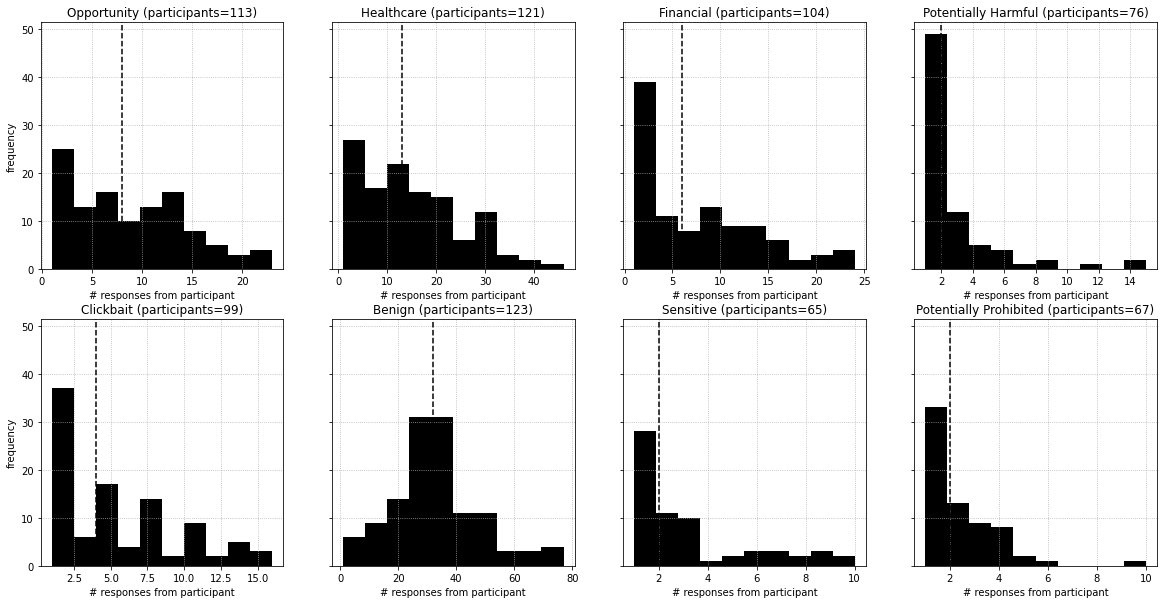

In [123]:
f, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
for i, c in enumerate(codelist):
    x, y = int(i > 3), i % 4
    axs[x][y].hist(parts_surveyed[c], bins=10, color='k')    
    axs[x][y].set_title(f'{c} (participants={len(parts_surveyed[c])})')
    axs[x][y].axvline(np.median(parts_surveyed[c]), ls='--', color='k')

for i in range(2):
    axs[i][0].set_ylabel('frequency')
    for j in range(4):  
        axs[i][j].grid(ls=':')
        axs[i][j].set_xlabel('# responses from participant')
        
plt.savefig('survey-imbalance.pdf', bbox_inches='tight', dpi=150)

In [ ]:
# what will survey sizes be if we were to fill in n-t?

# this is actually a harder question to answer
# we need to compute from the ads that each participant has annotated currently

### Current Survey Statistics

Most important questions below to answer **for every code:**
- how many participants were surveyed about it?
- how many responses per participant do we have?

### Further survey badness analyses

- **Can we get realistically 15 responses from all participants?**
    - For each participant, do we have enough annotated ads to be able to reach 15 for each code?
    - What if n=10?
- How many of the healthcare responses are alongside the "Study" code?

## After Balancing Survey

I'm primarily concerned with the average **size** of the surveys.

In [11]:
balancing_root = '../../../db-processing/surveys/balancing-survey/'
available_codes = pd.read_csv(os.path.join(balancing_root, 'available_code_counts.csv'))

nonresponders = open(os.path.join(balancing_root, 'nonresponders.txt')).readlines()
nonresponders = [n.strip() for n in nonresponders]

In [7]:
len(pids_active)

137

In [10]:
available_codes.head()

,pid,code,done,available
0,978584,Clickbait,11,18
1,978584,Potentially Prohibited,3,9
2,978584,Sensitive,1,4
3,978584,Potentially Harmful,6,12
4,978584,Financial,11,14


In [14]:
surveylens = {pid: {} for pid in pids_active if pid not in nonresponders}

In [93]:
N = 15
surveylens = {pid: {} for pid in pids_active if pid not in nonresponders}
lengths_summary = {}

for N in [5, 10, 15]:
    print('=='*20)
    for pid in pids_active:
        if pid in nonresponders:
            continue
        subset = available_codes[available_codes['pid'] == pid]
        for i in range(subset.shape[0]):        
            row = subset.iloc[i]
            code, done, available = row['code'], row['done'], row['available']

            remaining = min(N-done, 0)
            surveylens[pid][code] = min(available-remaining, N)                

        surveylens_total = {p: sum(surveylens[p].values()) for p in pids_active if p not in nonresponders}
        
    for c in codelist:
        # median number of *new* responses per participant with new survey?
        arr = [surveylens[p].get(c, 0) for p in pids_active if p not in nonresponders]
        print(c, 'median:', np.median(arr), 'max:', max(arr), 'mean:', round(np.mean(arr), 2))

    lengths = list(surveylens_total.values())
    lengths_summary[N] = lengths
    print(f'K={N}, survey size stats -- max: {max(lengths)}, median: {np.median(lengths)}, mean: {round(np.mean(lengths), 2)}\n')

Opportunity median: 5.0 max: 5 mean: 3.51
Healthcare median: 5.0 max: 5 mean: 4.25
Financial median: 3.0 max: 5 mean: 2.77
Potentially Harmful median: 1.0 max: 5 mean: 1.76
Clickbait median: 1.0 max: 5 mean: 2.17
Benign median: 0.0 max: 0 mean: 0.0
Sensitive median: 2.0 max: 5 mean: 2.55
Potentially Prohibited median: 0.0 max: 5 mean: 0.96
K=5, survey size stats -- max: 35, median: 17.0, mean: 17.97

Opportunity median: 6.0 max: 10 mean: 5.5
Healthcare median: 10.0 max: 10 mean: 7.29
Financial median: 2.0 max: 10 mean: 3.85
Potentially Harmful median: 1.0 max: 10 mean: 2.43
Clickbait median: 1.0 max: 10 mean: 3.29
Benign median: 0.0 max: 0 mean: 0.0
Sensitive median: 2.0 max: 10 mean: 3.27
Potentially Prohibited median: 0.0 max: 9 mean: 1.0
K=10, survey size stats -- max: 66, median: 24.0, mean: 26.63

Opportunity median: 5.0 max: 15 mean: 6.89
Healthcare median: 13.0 max: 15 mean: 9.63
Financial median: 2.0 max: 15 mean: 4.58
Potentially Harmful median: 1.0 max: 15 mean: 2.56
Clickbai

In [ ]:
# TODO: combine pid_codecounts and above to simulate median changes after full survey

In [64]:
for k in lengths_summary:
    print(k, len(lengths_summary[k]), sorted(lengths_summary[k], reverse=True)[:10])

5 115 [35, 35, 35, 35, 34, 34, 34, 33, 33, 32]
10 115 [66, 65, 63, 62, 60, 59, 59, 58, 58, 57]
15 115 [88, 84, 82, 80, 78, 76, 76, 74, 74, 74]


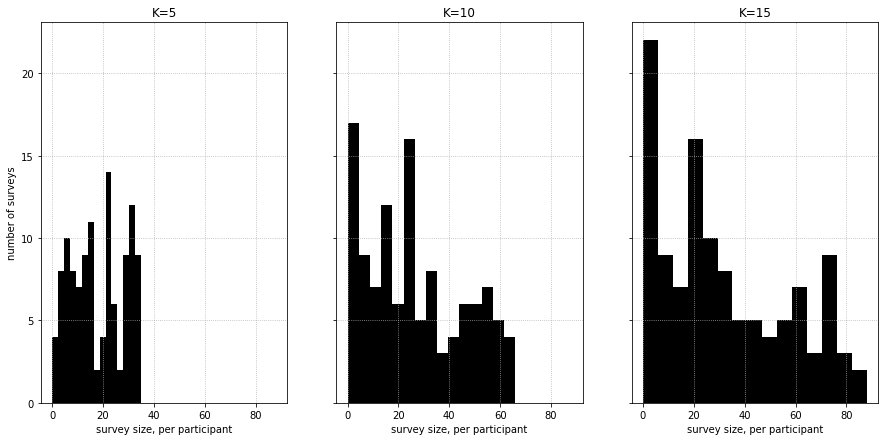

In [94]:
f, axs = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15, 7))

for i, k in enumerate([5, 10, 15]):
    axs[i].hist(lengths_summary[k], bins=15, color='k')
    axs[i].grid(ls=':')
    axs[i].set_title(f'K={k}')
    axs[i].set_xlabel('survey size, per participant')

axs[0].set_ylabel('number of surveys')
plt.savefig('size-simulation.pdf', bbox_inches='tight', dpi=150)